## Movie Sentiment Analysis using Deep Learning in Keras

#### The dataset 

can be downloaded from this Kaggle link.https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

The file contains 50,000 records and two columns: review and sentiment. 

The review column contains text for the review and the sentiment column contains sentiment for the review. 

The sentiment column can have two values i.e. "positive" and "negative" which makes our problem a binary classification problem.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

import matplotlib.pylab as plt
%matplotlib inline

from numpy import array

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D

from keras.layers.embeddings import Embedding

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


#### Importing and Analyzing the Dataset

In [2]:
location = r'D:\MYLEARN\datasets\IMDB Dataset.csv'

In [3]:
movie_reviews = pd.read_csv(location)

In [4]:
movie_reviews.isnull().values.any()

False

In [5]:
movie_reviews.shape

(50000, 2)

In [6]:
pd.set_option('max_colwidth', 120)

In [7]:
movie_reviews.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as ...",positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and g...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fightin...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portr...",positive


In [8]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

text contains punctuations, brackets, and a few HTML tags as well. We will preprocess this text 

distribution of positive and negative sentiments in our dataset.

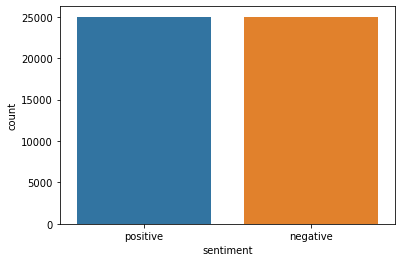

In [9]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews);

From the output, it is clear that the dataset contains equal number of positive and negative reviews

#### Data Preprocessing

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In the __preprocess_text()__ method the first step is to remove the HTML tags. To remove the HTML tags, __remove_tags()__ function has been defined. 

The remove_tags function simply replaces anything between opening and closing <> with an empty space.

Next, in the __preprocess_text__ function, everything is removed except capital and small English letters, which results in single characters that make no sense. For instance, when you remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s".

Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. 

Finally, we remove the multiple spaces from our text as well.

In [12]:
%%time
X = []

sentences = list(movie_reviews['review'])

for sen in sentences:
    X.append(preprocess_text(sen))

Wall time: 15.8 s


In [13]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

From the output, you can see that the HTML tags, punctuations and numbers have been removed. We are only left with the alphabets.

Next, we need to convert our labels into digits. 

Since we only have two labels in the output i.e. "positive" and "negative".

We can simply convert them into integers by replacing "positive" with digit 1 and negative with digit 0

In [15]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Finally, we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.

We can use train_test_split method from the sklearn.model.selection module

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### embedding layer. 

The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.

As a first step, we will use the __Tokenizer__ class from the keras.preprocessing.text module to create a word-to-index dictionary. 

In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [18]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

If you view the X_train variable in variable explorer, you will see that it contains 40,000 lists where each list contains integers. 

Each list actually corresponds to each sentence in the training set. 

You will also notice that the size of each list is different. This is because sentences have different lengths.

We set the maximum size of each list to 100. We can try a different size. 

The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called __padding__.

In [19]:
len(X_train)

40000

In [20]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
vocab_size

92547

In [21]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)

Now if we view the X_train or X_test, we will see that all the lists have same length i.e. 100. 

Also, the vocabulary_size variable now contains a value 92547 which means that our corpus has 92547 unique words.

#### GloVe embeddings to create our feature matrix

load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [22]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [23]:
embeddings_dictionary = dict()

400 mb file

In [24]:
location_glove_file = r'D:\MYLEARN\datasets\word2vec\glove.6B.100d.txt'

In [25]:
glove_file = open(location_glove_file, encoding="utf8")

In [26]:
i = 1
for line in glove_file:
    
    records = line.split()
    
    print(records)
    
    word    = records[0]
    
    print(word)
    
    if i==2:
        break
    
    i +=1 

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

In [27]:
%%time
for line in glove_file:
    
    records = line.split()
    word    = records[0]
    
    vector_dimensions = asarray(records[1:], dtype='float32')
    
    embeddings_dictionary[word] = vector_dimensions

Wall time: 26.5 s


Finally, we will create an __embedding matrix__ where each row number will correspond to the index of the word in the corpus. 

The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.

In [28]:
embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
len(embedding_matrix)

92547

In [30]:
embedding_matrix[:3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

embedding_matrix will contain 92547 rows (one for each word in the corpus). Now we are ready to create our deep learning models.

In [31]:
def plot_history(history):

    plt.plot(history.history['acc'], lab)
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')

#### 1. Using Simple Neural Network

In [32]:
model           = Sequential()
embedding_layer = Embedding(vocab_size, 
                            100, 
                            weights=[embedding_matrix], 
                            input_length=maxlen , 
                            trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

we create a __Sequential()__ model. 

Next, we create our __embedding layer__. The embedding layer will have an input length of 100, the output vector dimension will also be 100. 

The vocabulary size will be 92547 words. Since we are not training our own embeddings and using the GloVe embedding, we set trainable to False and in the weights attribute we pass our own embedding matrix.

The __embedding layer__ is then added to our model. 

Next, since we are directly connecting our embedding layer to densely connected layer, we flatten the embedding layer. 

Finally, we add a dense layer with __sigmoid__ activation function.

To compile our model, we will use the __adam__ optimizer, __binary_crossentropy__ as our loss function and __accuracy__ as metrics and then we will print the summary of our model:

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


Since there are 92547 words in our corpus and each word is represented as a 100-dimensional vector, the number of trainable parameter will be 92547x100 in the embedding layer. 

In the flattening layer, we simply multiply rows and column. 

Finally in the dense layer the number of parameters are 10000 (from the flattening layer) and 1 for the bias parameter, for a total of 10001.

#### train our model:

In [34]:
%%time
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 2s 72us/step - loss: 0.5984 - acc: 0.6775 - val_loss: 0.5313 - val_acc: 0.7356
Epoch 2/6
32000/32000 [==============================] - 2s 63us/step - loss: 0.4930 - acc: 0.7656 - val_loss: 0.5129 - val_acc: 0.7498
Epoch 3/6
32000/32000 [==============================] - 2s 61us/step - loss: 0.4572 - acc: 0.7861 - val_loss: 0.5126 - val_acc: 0.7485
Epoch 4/6
32000/32000 [==============================] - 2s 59us/step - loss: 0.4328 - acc: 0.8016 - val_loss: 0.5179 - val_acc: 0.7506
Epoch 5/6
32000/32000 [==============================] - 2s 60us/step - loss: 0.4165 - acc: 0.8113 - val_loss: 0.5231 - val_acc: 0.7462
Epoch 6/6
32000/32000 [==============================] - 2s 62us/step - loss: 0.4059 - acc: 0.8178 - val_loss: 0.5302 - val_acc: 0.7466
Wall time: 12.7 s


In [35]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plot_history(history)

10000/10000 [==============================] - 1s 73us/step
Test Score: 0.5360468801021576
Test Accuracy: 0.7458999752998352


NameError: name 'lab' is not defined

#### 2. Using SimpleRNN

In [119]:
from keras import Sequential
from keras.layers import Embedding, SimpleRNN

In [120]:
model           = Sequential()
embedding_layer = Embedding(vocab_size, 
                            100, 
                            weights=[embedding_matrix], 
                            input_length=maxlen , 
                            trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [121]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 9,284,141
Trainable params: 29,441
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [122]:
%%time
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 20s 610us/step - loss: 0.6803 - acc: 0.5677 - val_loss: 0.6588 - val_acc: 0.5949
Epoch 2/6
32000/32000 [==============================] - 19s 593us/step - loss: 0.6592 - acc: 0.5994 - val_loss: 0.6361 - val_acc: 0.6309
Epoch 3/6
32000/32000 [==============================] - 19s 590us/step - loss: 0.6390 - acc: 0.6318 - val_loss: 0.5552 - val_acc: 0.7319
Epoch 4/6
32000/32000 [==============================] - 19s 598us/step - loss: 0.6428 - acc: 0.6173 - val_loss: 0.6678 - val_acc: 0.5799
Epoch 5/6
32000/32000 [==============================] - 19s 592us/step - loss: 0.6597 - acc: 0.5952 - val_loss: 0.6696 - val_acc: 0.5785
Epoch 6/6
10000/10000 [==============================] - 3s 338us/step
Wall time: 1min 58s


10000/10000 [==============================] - 3s 346us/step
Test Score: 0.6298365400314331
Test Accuracy: 0.6474000215530396


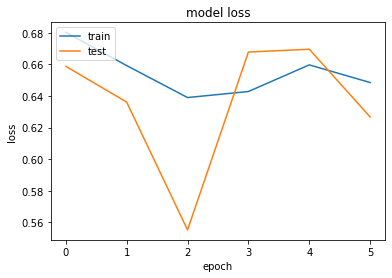

In [123]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plot_history(history)

#### Using Recurrent Neural Network (LSTM)

In [70]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [71]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            100, 
                            weights=[embedding_matrix], 
                            input_length=maxlen , 
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

we start by initializing a sequential model followed by the creation of the embedding layer. 

Next, we create an LSTM layer with 128 neurons 

In [72]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [39]:
%%time
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 67s 2ms/step - loss: 0.5378 - acc: 0.7240 - val_loss: 0.4537 - val_acc: 0.7857
Epoch 2/6
32000/32000 [==============================] - 66s 2ms/step - loss: 0.4467 - acc: 0.7946 - val_loss: 0.4089 - val_acc: 0.8155
Epoch 3/6
32000/32000 [==============================] - 67s 2ms/step - loss: 0.3971 - acc: 0.8192 - val_loss: 0.3994 - val_acc: 0.8167
Epoch 4/6
32000/32000 [==============================] - 65s 2ms/step - loss: 0.3629 - acc: 0.8390 - val_loss: 0.3483 - val_acc: 0.8481
Epoch 5/6
32000/32000 [==============================] - 64s 2ms/step - loss: 0.3393 - acc: 0.8502 - val_loss: 0.3351 - val_acc: 0.8546
Epoch 6/6
10000/10000 [==============================] - 10s 1ms/step
Wall time: 6min 43s


In [40]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.338674317073822
Test Accuracy: 0.8476999998092651


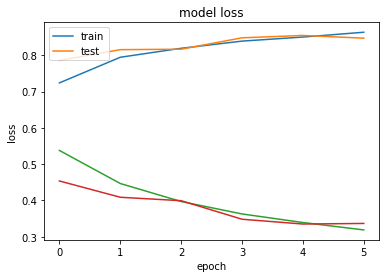

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

## Making Predictions on Single Instance

In [44]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


You can clearly see that this is __negative__ review. 

To predict the sentiment of this review, we have to convert this review into numeric form. We can do so using the tokenizer that we created in word embedding section. The text_to_sequences method will convert the sentence into its numeric counter part.

Next, we need to pad our input sequence as we did for our corpus. 

Finally, we can use the predict method of our model and pass it our processed input sequence. 

In [45]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.5479413]], dtype=float32)

The results show that LSTM, which is a variant of RNN outperforms simple neural network.

In [46]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [37]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])